In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os

# For viewing grids purpose
import matplotlib.animation as animation
from IPython.display import HTML
import pickle

In [ ]:
# Configuration
batch_size = 64
image_size = 64
image_dim = 3
channels = 3
z_dim = 100
hidden_dim = 64
epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download cats dataset from here:
[Cat_Dataset_15k](https://drive.google.com/file/d/1zNWRIkelSD4BHMYtvxT0zbvJec4dGKnG/view?usp=sharing)

In [ ]:
folder_path = "data/cats"
# Check if the folder already exists
if not os.path.exists(folder_path):
    # If it doesn't exist, create the folder
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder 'data/cats' created successfully.


In [ ]:
# -qq mean print nothing
!unzip -qq "/content/drive/MyDrive/Datasets/cats.zip" -d "data/cats"

# Remove redundant hidden files
!rm -R /content/data/.ipynb_checkpoints
!rm -R /content/data/cats/.ipynb_checkpoints

## If no .ipynb_checkpoints found, it was correct.

rm: cannot remove '/content/data/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/data/cats/.ipynb_checkpoints': No such file or directory


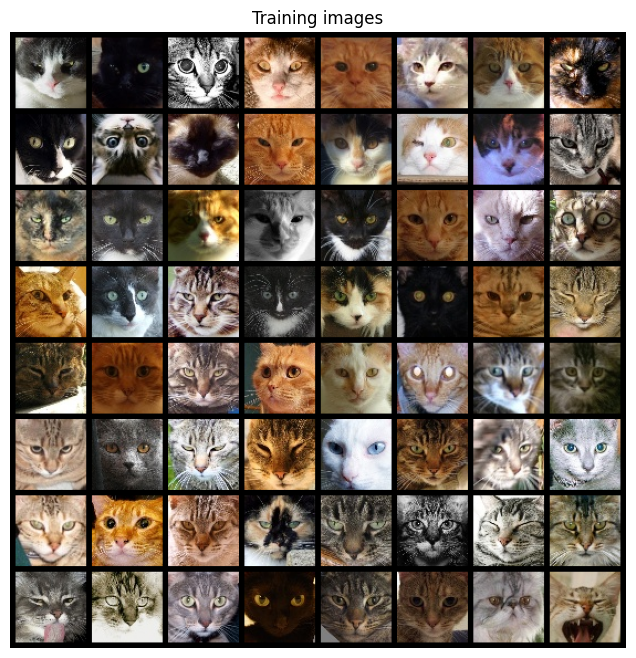

In [ ]:
# Dataset
transform = transforms.Compose([
	transforms.Resize(image_size),
	transforms.CenterCrop(image_size),
	transforms.ToTensor()
])

dset = ImageFolder(root="/content/data", transform=transform)
loader = DataLoader(dataset=dset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [ ]:
class Generator(nn.Module):
	def __init__(self, image_dim, z_dim, hidden_dim):
		super().__init__()
		def block(in_features, out_features, kernel_size, stride, padding, last_layer=False):
			layers = []
			layers.append(
				nn.ConvTranspose2d(
					in_channels=in_features,
					out_channels=out_features,
					kernel_size=kernel_size,
					stride=stride,
					padding=padding,
					bias=False
				)
			)
			if not last_layer:
				layers.extend([
					nn.BatchNorm2d(num_features=out_features),
					nn.ReLU(inplace=True)
				])
			else:
				layers.append(
					nn.Tanh()
				)
			return layers

		self.model = nn.Sequential(
			# (100, 1, 1)
			*block(z_dim, hidden_dim * 8, 4, 1, 0), # (512, 4, 4)
			*block(hidden_dim * 8, hidden_dim * 4, 4, 2, 1), # (256, 8, 8)
			*block(hidden_dim * 4, hidden_dim * 2, 4, 2, 1), # (128, 16, 16)
			*block(hidden_dim * 2, hidden_dim * 1, 4, 2, 1), # (64, 32, 32)
			*block(hidden_dim, image_dim, 4, 2, 1, last_layer=True) # (3, 64, 64)
		)

	def forward(self, x):
		return self.model(x)

In [ ]:
class Discriminator(nn.Module):
	def __init__(self, image_dim, hidden_dim):
		super().__init__()

		def block(in_features, out_features, kernel_size, stride, padding, first_layer=False, last_layer=False):
			layers = []
			layers.append(
				nn.Conv2d(
					in_channels=in_features,
					out_channels=out_features,
					kernel_size=kernel_size,
					stride=stride,
					padding=padding,
					bias=False)
			)
			if first_layer:
				layers.append(
					nn.LeakyReLU(negative_slope=0.2, inplace=True)
				)

			elif last_layer:
				layers.extend([
					# nn.LeakyReLU(negative_slope=0.2),
          nn.Sigmoid()
        ])

			else:
				layers.extend([
					# nn.Dropout(p=0.8),
					nn.BatchNorm2d(num_features=out_features),
					nn.LeakyReLU(negative_slope=0.2, inplace=True)
				])

			return layers

		self.model = nn.Sequential(
      # (3, 64, 64)
			*block(image_dim, hidden_dim, 4, 2, 1, first_layer=True), # (64, 32, 32)
			*block(hidden_dim * 1, hidden_dim * 2, 4, 2, 1), # (128, 16, 16)
			*block(hidden_dim * 2, hidden_dim * 4, 4, 2, 1), # (256, 8, 8)
			*block(hidden_dim * 4, hidden_dim * 8, 4, 2, 1), # (512, 4, 4)
			*block(hidden_dim * 8, 1, 4, 1, 0, last_layer=True), # (1)
		)

	def forward(self, x):
		return self.model(x)

In [ ]:
def weight_init(m):
	classname = m.__class__.__name__
	if classname.find('Conv') != -1:
		nn.init.normal_(tensor=m.weight.data, mean=0., std=0.02)
	elif classname.find('BatchNorm') != -1:
		nn.init.normal_(tensor=m.weight.data, mean=1., std=0.02)
		nn.init.constant_(m.bias.data, 0)

In [ ]:
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
main_path = '/content/drive/MyDrive/GANs/Cat Generator With DCGANs'
outputs_folder = 'Training Outputs'
outputs_path = os.path.join(main_path, outputs_folder)

def view_outputs_during_training(epoch, batch_idx, save=True, outputs_path=outputs_path, plot=True, return_grid=False):
  with torch.no_grad():
    fake = gen(fixed_noise).detach().to(device)
    plt.figure(figsize=(8, 8))
    grid = make_grid(fake[:64], padding=5, normalize=True).cpu().numpy().transpose((1, 2, 0))

    if plot:
      plt.axis("off")
      plt.title(f"[{epoch}/{epochs}][{batch_idx}/{len(loader)}]")
      plt.imshow(grid)
      plt.show()

    if save:
        img_path = os.path.join(outputs_path, f'[{epoch}-{epochs}][{batch_idx}-{len(loader)}].png')
        plt.imsave(img_path, grid)

    # Return to save to img_list
    if return_grid:
      return grid

In [ ]:
gen = Generator(image_dim=image_dim, z_dim=z_dim, hidden_dim=hidden_dim).to(device)
disc = Discriminator(image_dim=image_dim, hidden_dim=hidden_dim).to(device)

gen_model_file = 'gen1.pth'
gen_model_path = os.path.join(main_path, gen_model_file)

disc_model_file = 'disc1.pth'
disc_model_path = os.path.join(main_path, disc_model_file)

gen.apply(weight_init)
disc.apply(weight_init)

learning_rate=2e-4
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Load state dict
# gen.load_state_dict(torch.load(gen_model_path))
# disc.load_state_dict(torch.load(disc_model_path))


# Training loop
img_list = []
D_loss = []
G_loss = []
print_loss_interval = 50
view_grid_interval = 200
# save_images_animation_interval = 50
# save_output_images_interval = 50

criterion = nn.BCELoss()

print("Starting training...")
for epoch in range(epochs):
  for batch_idx, (real_images, _) in enumerate(loader):
    ### Discriminator ###
    real = real_images.to(device)
    batch = real.shape[0]

    noise = torch.randn((batch, z_dim, 1, 1)).to(device)
    fake = gen(noise).to(device)

    real_pred = disc(real).reshape(-1)
    fake_pred = disc(fake.detach()).reshape(-1)

    ones = torch.ones_like(real_pred)
    zeros = torch.zeros_like(fake_pred)

    d_loss_real = criterion(real_pred, ones)
    d_loss_fake = criterion(fake_pred, zeros)

    d_loss = (d_loss_real + d_loss_fake)
    D_loss.append(d_loss.item())

    ### Update discriminator ###
    opt_disc.zero_grad()
    d_loss.backward()
    opt_disc.step()

    ### Generator ###
    output = disc(fake).reshape(-1)
    g_loss = criterion(output, torch.ones_like(output))
    G_loss.append(g_loss.item())

    ### Update Generator ###
    opt_gen.zero_grad()
    g_loss.backward()
    opt_gen.step()

    # Print loss after `print_loss_interval` batches.
    if batch_idx % print_loss_interval == 0:
      print(f"[{epoch}/{epochs}][{batch_idx}/{len(loader)}]\tD_loss: {d_loss.item()}\tG_loss: {g_loss.item()}")

    # View grid images after `view_grid_interval` batches.
    if batch_idx % view_grid_interval == 0:
      grid = view_outputs_during_training(epoch=epoch, batch_idx=batch_idx, save=True, return_grid=True)
      img_list.append(grid)


    # Save images to drive
    # if batch_idx % save_output_images_interval == 0:
    #   view_outputs_during_training(epoch=epoch, batch_idx=batch_idx, save=True, plot=False)

    # Save images to pickle to create animation object
    # if batch_idx % save_images_animation_interval == 0:
    #   grid = view_outputs_during_training(epoch=epoch, batch_idx=batch_idx, plot=False, save=False, return_grid=True)
    #   img_list.append(grid)

Things to do after training (even if it is interrupted)

In [ ]:
pickle_file = 'img_list.pkl'

img_list_full_path = os.path.join(main_path, pickle_file)

# Save img_list to a file
with open(img_list_full_path, 'wb') as f:
    pickle.dump(img_list, f)

# Save losses into a file
loss_file = 'loss_analysis.csv'
loss_file_path = os.path.join(main_path, loss_file)

with open(loss_file_path, 'w') as f:
    f.write("Epoch,Batch_idx,D_loss,G_loss\n")
    for index, (d_loss, g_loss) in enumerate(zip(D_loss, G_loss)):
        epoch = index // len(loader)
        batch_idx = index % len(loader)
        f.write(f"{epoch},{batch_idx},{d_loss},{g_loss}\n")

# Save models
torch.save(gen.state_dict(), gen_model_path)
torch.save(disc.state_dict(), disc_model_path)

Create animation object to view how models learnt!

In [ ]:
# Later, to load img_list from the file
with open(img_list_full_path, 'rb') as f:
    img_list = pickle.load(f)

# Create animation object
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())